### ANÁLISE DE DESPESAS BRASIL - 2014 a 01/2025 

Nesse notebook vamos analisar as despesas do Brasil ao longo de 2014 até 01/2025, mas os dados podem ser aumentados a qualquer momento, bastando sua disponibilização no Portal da Transparência

Primeiramente, vamos abrir o arquivo com Spark para poder usufruir do seu paralelismo:

In [ ]:
# Início do notebook

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, mean, stddev, when
import pyspark.sql.functions as F

# Cria a sessão do Spark
spark = SparkSession.builder \
    .appName("AnaliseDespesasBrasil") \
    .master("local[4]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .getOrCreate()

# Lê todos os arquivos CSV da pasta "data"
# Usamos opções para header e delimitador
df = spark.read.options(header=True, delimiter=";", encoding="ISO-8859-1", inferSchema=False).csv("data/raw/*.csv")

# Exibe o esquema para conferir os tipos
df.printSchema()
df.show()



root
 |-- Ano e mês do lançamento: string (nullable = true)
 |-- Código Órgão Superior: string (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: string (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: string (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: string (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: string (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: string (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: string (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: string (nullable = true)
 |-- Nome Programa Orçamentário: string (nullable = true)
 |-- Código Ação: string (nullable = true)
 |-- Nome Ação: string (nullable = true)
 |-- Código Plano Orçamentário: s

Como não conhecemos bem os dados, vamos explorar algumas colunas, converter outras e procurar saber com que tipo de dados estamos lidando:

In [11]:
#ENGENHARIA DOS DADOS (correções de tipos)
# Conversão dos valores monetários
df = df.withColumn("Valor Empenhado (R$)", regexp_replace(col("Valor Empenhado (R$)"), ",", ".").cast("double")) \
    .withColumn("Valor Liquidado (R$)", regexp_replace(col("Valor Liquidado (R$)"), ",", ".").cast("double")) \
    .withColumn("Valor Pago (R$)", regexp_replace(col("Valor Pago (R$)"), ",", ".").cast("double")) \
    .withColumn("Valor Restos a Pagar Inscritos (R$)", regexp_replace(col("Valor Restos a Pagar Inscritos (R$)"), ",", ".").cast("double")) \
    .withColumn("Valor Restos a Pagar Cancelado (R$)", regexp_replace(col("Valor Restos a Pagar Cancelado (R$)"), ",", ".").cast("double")) \
    .withColumn("Valor Restos a Pagar Pagos (R$)", regexp_replace(col("Valor Restos a Pagar Pagos (R$)"), ",", ".").cast("double"))

# Conversão para inteiro somente das colunas que já foram testadas e aprovadas
int_columns = [
    "Código Órgão Superior",
    "Código Órgão Subordinado",
    "Código Unidade Gestora",
    "Código Gestão",
    "Código Unidade Orçamentária",
    "Código Função",
    "Código Subfução",
    "Código Programa Orçamentário",
    "Código Localizador",
    "Código Elemento de Despesa",
    "Código Modalidade da Despesa",
    "Código Autor Emenda"
]

for c in int_columns:
    df = df.withColumn(c, col(c).cast("integer"))
    print(f"A coluna {c} convertida para inteiro.")


A coluna Código Órgão Superior convertida para inteiro.
A coluna Código Órgão Subordinado convertida para inteiro.
A coluna Código Unidade Gestora convertida para inteiro.
A coluna Código Gestão convertida para inteiro.
A coluna Código Unidade Orçamentária convertida para inteiro.
A coluna Código Função convertida para inteiro.
A coluna Código Subfução convertida para inteiro.
A coluna Código Programa Orçamentário convertida para inteiro.
A coluna Código Localizador convertida para inteiro.
A coluna Código Elemento de Despesa convertida para inteiro.
A coluna Código Modalidade da Despesa convertida para inteiro.
A coluna Código Autor Emenda convertida para inteiro.


Aqui vamos converter o campo de data para um formato de date para permitir um melhor processamento dos dados

In [12]:
df = df.withColumn("Ano e mês do lançamento",
                   F.to_date(F.concat(col("Ano e mês do lançamento"), F.lit("/01")), "yyyy/MM/dd"))


Essa célula usamos para exibir como está o nosso dataframe até o momento. Parece estar bem melhor o schema dele, mais bem estruturado

In [13]:
# Exibe o esquema e alguns registros para conferir
df.printSchema()
df.show()


root
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: integer (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Nome Programa Orçamentário: string (nullable = true)
 |-- Código Ação: string (nullable = true)
 |-- Nome Ação: string (nullable = true)
 |-- Código Plano Orçamentá

Vamos salvar esse dataframe agora para permitir que tenhamos um arquivo de dados mais enxuto e mais apropriado para a análise. Para passarmos a trabalhar com ele agora, permitindo maior velocidade e performance, vamos gravar e reabrir o dataframe a partir do novo arquivo

In [ ]:
import os
import glob

# Define os caminhos
csv_path_pattern = "data/raw/*.csv"
parquet_path = "data/Despesas"

# Salva o dataframe em parquet com compressão snappy
df.write.mode("overwrite").option("compression", "snappy").parquet(parquet_path)

# Calcula o tamanho total dos arquivos CSV originais
csv_files = glob.glob(csv_path_pattern)
total_csv_size = sum(os.path.getsize(f) for f in csv_files)

# Calcula o tamanho total dos arquivos do parquet (o parquet é uma pasta com vários arquivos)
total_parquet_size = 0
for root, dirs, files in os.walk(parquet_path):
    for file in files:
        total_parquet_size += os.path.getsize(os.path.join(root, file))

print("Tamanho total dos CSVs (bytes):", total_csv_size)
print("Tamanho total do Parquet com snappy (bytes):", total_parquet_size)

# Destrói o dataframe atual
del df

# Recria o dataframe lendo os dados do parquet
df = spark.read.parquet(parquet_path)

print("Schema do dataframe recriado a partir do Parquet:")
df.printSchema()
df.show()

Tamanho total dos CSVs (bytes): 7416331055
Tamanho total do Parquet com snappy (bytes): 450221117
Schema do dataframe recriado a partir do Parquet:
root
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: integer (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Nome Programa Or

In [18]:
# Exemplo: Cálculo de estatísticas globais para 'Valor_Empenhado'
stats = df.agg(
    mean("Valor Empenhado (R$)").alias("media_emp"),
    stddev("Valor Empenhado (R$)").alias("std_emp")
).collect()[0]

media_emp = stats["media_emp"]
std_emp = stats["std_emp"]

print("Média Valor Empenhado:", media_emp)
print("Desvio Padrão:", std_emp)

# Filtrando possíveis anomalias (usando 3 desvios-padrão como critério)
df_anomalias = df.filter(
    (col("Valor Empenhado (R$)") > media_emp + 3 * std_emp) | 
    (col("Valor Empenhado (R$)") < media_emp - 3 * std_emp)
)

print("Quantidade de registros anômalos (Valor Empenhado):", df_anomalias.count())

Média Valor Empenhado: 4306719.821669389
Desvio Padrão: 813476771.7336167


Quantidade de registros anômalos (Valor Empenhado): 1463


In [ ]:
# Análise de texto utilizando Pipeline do Spark ML

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Supondo que a coluna de interesse seja "Descrição Complementar Localizador"
# Primeiro, filtramos registros onde essa coluna não esteja vazia
df_text = df.filter(col("Descrição Complementar Localizador").isNotNull())

# Criação dos estágios do pipeline
tokenizer = Tokenizer(inputCol="Descrição Complementar Localizador", outputCol="words")
brazilian_stopwords = ["a", "à", "ao", "aos", "as", "às", "de", "do", "da", "dos", "das", "em", "no", "na", "nos", "nas", "por", "para", "com", "sem", "que", "e", "ou", "porém", "mas"]
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=brazilian_stopwords)
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Definindo um número de clusters; esse valor pode ser ajustado conforme a exploração
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=10)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])

# Treina o pipeline
model = pipeline.fit(df_text)
df_clustered = model.transform(df_text)

# Exibe a contagem de registros por cluster (clusters com poucos registros podem indicar anomalias)
df_clustered.groupBy("cluster").count().orderBy("count").show()

# Outras análises podem incluir a correlação entre os clusters dos textos e os valores numéricos dos gastos.

# Finaliza a sessão do Spark (quando terminar todas as análises)
spark.stop()

ERROR:root:KeyboardInterrupt while sending command.               (20 + 4) / 73]
Traceback (most recent call last):
  File "/Users/leonardodias/anaconda3/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/leonardodias/anaconda3/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/leonardodias/anaconda3/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

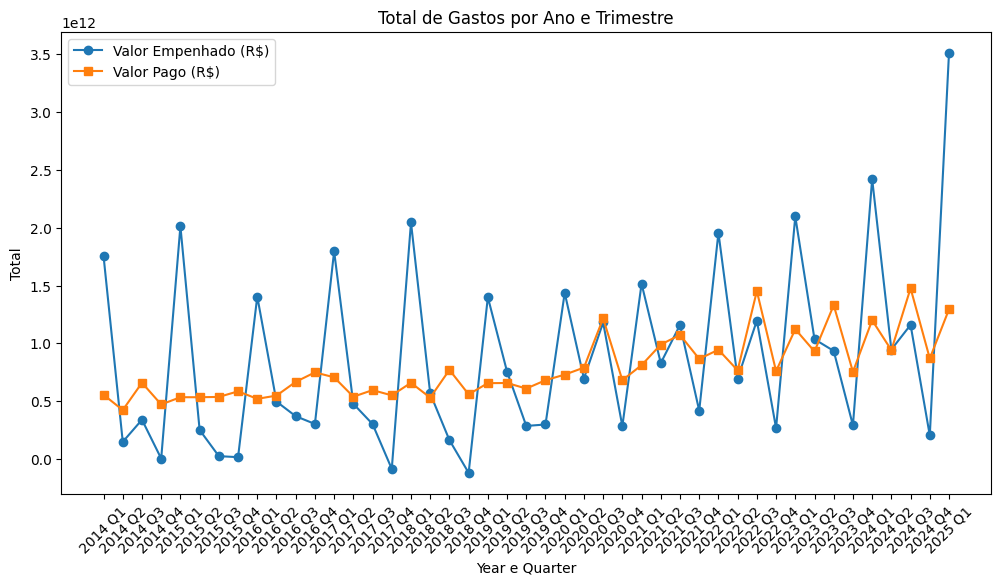

In [31]:
import pandas as pd
# Group data by date and compute the sum for both "Valor Empenhado (R$)" and "Valor Pago (R$)"
df_grouped = df.groupBy(
    F.year("Ano e mês do lançamento").alias("year"),
    F.quarter("Ano e mês do lançamento").alias("quarter")
).agg(
    F.sum("Valor Empenhado (R$)").alias("total_empenhado"),
    F.sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year", "quarter")

# Convert the Spark DataFrame to a pandas DataFrame
df_grouped_pd = df_grouped.toPandas()
df_grouped_pd['year_quarter'] = df_grouped_pd['year'].astype(str) + " Q" + df_grouped_pd['quarter'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_empenhado'], marker='o', label="Valor Empenhado (R$)")
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_pago'], marker='s', label="Valor Pago (R$)")
plt.title("Total de Gastos por Ano e Trimestre")
plt.xlabel("Year e Quarter")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.legend()
plt.show()
